In [1]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
# Import the required packages

import numpy as np
import matplotlib.pyplot as plt
import lightcones.linalg as ll
import lightcones.models as lm
import lightcones.jumps as lj
import lightcones.space as ls
from scipy.linalg import expm
import math

In [3]:
def compute_S_for_k(k):
    # chaotic system is quantum top
    j = 20
    top = lm.top(j)
    # ancilla is also quantum top of the same j
    aux = top

    # initial states
    psi_0 = top.vac()
    psi_aux_0 = aux.state_with(j_z=0)
    
    tau = 1
    p = 1.7
    Hy = p / tau * top.j_y
    Hz = k / 2 / top.j * (top.j_z - 0.1 * top.eye()) @ (top.j_z - 0.1 * top.eye())
    Hy_ = Hy.todense()
    Hz_ = Hz.todense()
    Uy = expm(-1j*Hy_)
    # kick acts as identity on ancilla
    Uz = ll.kron(expm(-1j*Hz_), aux.eye())

    # we will consider a bipartite of top \otimes ancilla
    bp = ls.bipartite(top.dimension, aux.dimension)
    
    # interaction with the ancilla
    g = 0.005
    Hint = g * ll.kron(top.j_y, aux.j_y)
    Hint_ = Hint.todense()
    Uint = expm(-1j*Hint_)

    # iterate evolutions
    n = 1000
    n_skip = 50
    psi = psi_0
    ln_P = 0
    for i in range(n + n_skip):
        # 1 kick period free evolution
        psi = Uy @ psi
        # entangle with the ancilla
        psi_bp = bp.kron(psi, psi_aux_0)
        psi_bp = Uint @ psi_bp
        # apply kick
        psi_bp = Uz @ psi_bp
        # trace out ancilla
        rho_top = bp.trace_out_R(psi_bp)
        # sample quantum jump
        jump_ind, jump_basis, jump_P = lj.make_jump_(rho_top)
        # update state
        psi = jump_basis[:, jump_ind]
        # update ln_P
        if i >= n_skip:
            ln_P += -math.log(jump_P[jump_ind])
    return ln_P / n

In [4]:
from joblib import Parallel, delayed

k_grid = np.arange(0,7,0.3)
S = Parallel(n_jobs=-1)(
    delayed(compute_S_for_k)(k) 
    for k in k_grid
)

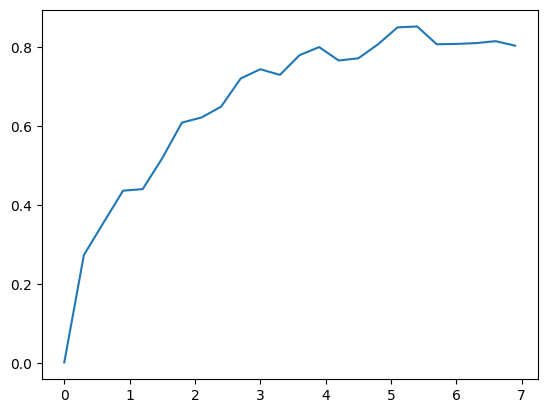

In [5]:
plt.plot(np.arange(0,7,0.3), np.array(S))